# Static Convolutional Neural Network
***
# Table of Contents
1.   [Imports](#Imports)
2.   [Dataset Object](#Dataset-Object)
3.   [Data Loading](#Data-Loading)
4.   [Model](#Model)
5.   [Setup](#Setup)
6.   [Training](#Training)
7.   [Testing](#Testing)

# Imports

The necessary libraries are imported at this stage.

* torch - Python pytorch library used to create and train the CNN
* numpy - Efficient data arrays
* pandas - Data applications
* sklearn - Provides a number of models, metrics and general functionality for machine learning
* matplotlib - Provides plotting.

In [1]:
import torch
import numpy as np
import pandas as pd
from torch.nn import Linear, ReLU, Flatten, Sequential, Conv1d, Module, CrossEntropyLoss, Dropout, Softmax, LogSoftmax
from torch.optim import Adam
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix
import Helper as h

# Dataset Object

Although not fully required it is helpful to create a custom torch.utils.data.Dataset when using the pytorch library.
This makes the splitting and feeding of data into the network easier.

## Encoding

A dict is defined 0-3 for the Static activities in the dataset.

In [2]:
activity_encode =   {
                        "WALKING": 4,
                        "STAIRS DN": 5,
                        "STAIRS UP": 6,
                        "SWIMMING" : 7,
                        "PUSH UP" : 8,
                        "JUMPING" : 9,
                        "DRIVING": 0,
                        "LAYING": 1,
                        "SITTING": 2,
                        "STANDING": 3
                    }

## Dataset

The object is defined as below for the UCI dataset. 3 functions need to be implemented **__init__**, **__len__** and
**__getitem__**.

In initialisation the data is split into X and y variables and turned into tensors.

The X variable has shape (row_count, 1, feature_count). 1 since there is only one channel of data.

The dynamic features are removed.

In [3]:
class OUR_Static_Dataset(Dataset):

    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)
        data['Label'] = data['Label'].map(activity_encode)
        data, _ = [x for _, x in data.groupby(data['Label'] > 3)]
        self.data_y = data['Label'].values
        data = pd.DataFrame(data.drop(['Label'],axis=1))
        self.data_x = np.array(data)
        # [batch, channels, features]
        self.data_x = self.data_x.reshape(len(self.data_x), 1, 589)
        self.data_x  = torch.from_numpy(self.data_x)
        self.data_y = self.data_y.astype(int)
        self.data_y = torch.from_numpy(self.data_y)

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]


Initialise the 3 datasets that will be used.

In [4]:
train_data = OUR_Static_Dataset(csv_file='Our Dataset/train.csv')
valid_data = OUR_Static_Dataset(csv_file='Our Dataset/valid.csv')
test_data = OUR_Static_Dataset(csv_file='Our Dataset/test.csv')

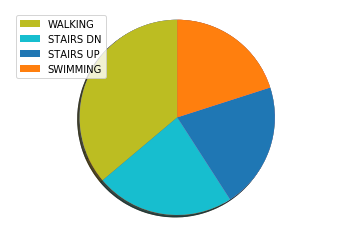

In [5]:
h.pie('Our Dataset/train.csv', 'OUR Data Static Training Data Distribution', activity_encode, 3, 'Label')
h.pie('Our Dataset/valid.csv', 'OUR Data Static Validation Data Distribution', activity_encode, 3, 'Label')
h.pie('Our Dataset/test.csv', 'OUR Data Static Testing Data Distribution', activity_encode, 3, 'Label')

# Data Loading

Using the DataLoader object load in the data, shuffling and assigning a batch size of 64.

In [6]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

# Model

The Static CNN is implemented below, documentation is provided in the report.

In [7]:
class StaticCNN(Module):
    def __init__(self):
        super(StaticCNN, self).__init__()

        self.cnn_layers = Sequential(
            Conv1d(1, 30, kernel_size=tuple([3])),
            ReLU(),
            Conv1d(30, 50, kernel_size=tuple([3])),
            ReLU(),
            Conv1d(50, 100, kernel_size=tuple([3])),
            ReLU(),
            Flatten()
        )

        self.linear_layers = Sequential(
            Dropout(0.5),
            Linear(58300, 4),
            LogSoftmax(dim=1)
        )

    # Defining the forward pass
    def forward(self, x):
        # print(x.shape) # ([32, 1, 325])
        x = self.cnn_layers(x)
        # print(x.shape) # ([32, 31900])
        x = self.linear_layers(x)
        # print(x.shape) # ([32, 4])
        return x

# Setup

In this step we initialise the loss, optimizer and model objects. For this problem we used cross entropy loss and the
adam optimizer.

If found we use cuda GPU acceleration to make the process faster.

In [8]:
criterion = CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

model = StaticCNN()

train = True

# Set for training
if train:
    epochs = 10
    step = epochs//5
    optimizer = Adam(model.parameters(), lr=0.0005)
    model.to(device)
# Load Existing, (do not train again if loaded)
else:
    state_dict = torch.load('Models/ODSCNN.pth')
    model.load_state_dict(state_dict)

# Training

In this step the model is trained. Validation is done so we can observe the progress.

In [9]:
data_loaders = {}
data_loaders['train'] = trainloader
data_loaders['val'] = validloader
data_lengths = {"train": len(train_data), "val": len(valid_data)}

for epoch in range(epochs):
    if (epoch+1) % step == 0:
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for data in data_loaders[phase]:
            inputs, labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            # forward pass to get outputs
            output = model(inputs)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output, labels)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.item()

        epoch_loss = running_loss / data_lengths[phase]
        if (epoch+1) % step == 0:
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

Epoch 1/9
----------
train Loss: 29.0196
val Loss: 1.1103
Epoch 3/9
----------
train Loss: 3.9737
val Loss: 1.3440
Epoch 5/9
----------
train Loss: 1.1639
val Loss: 0.0726
Epoch 7/9
----------
train Loss: 0.1944
val Loss: 0.0419
Epoch 9/9
----------
train Loss: 0.0998
val Loss: 0.0650


# Testing

Finally the model is tested on the test set.

In [10]:
model.cpu()
predictions = []
test_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.float(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
            predictions.append(p)

        for l in labels:
            test_labels.append(l)


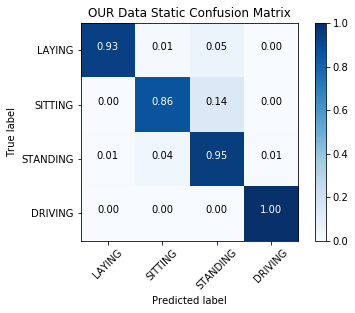

In [11]:
cnf_matrix = confusion_matrix(test_labels, predictions)
np.set_printoptions(precision=2)

classes =   {
                "LAYING": 0,
                "SITTING": 1,
                "STANDING": 2,
                "DRIVING": 3,
            }
h.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,title='OUR Data Static Confusion Matrix')

In [12]:
# Print metrics
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(test_labels, predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(test_labels, predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(test_labels, predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(test_labels, predictions, average='weighted')))

Final accuracy score on the testing data: 0.9393
Final F-score on the testing data: 0.9397
Final precision score on the testing data: 0.9403
Final recall score on the testing data: 0.9393


In [13]:
# Save model for neutron
device = 'cpu'
batch = next(iter(trainloader))[0].to(device).float()
torch.onnx.export(model, batch, 'Visualizations/CNN ONNX/ODSCNN.onnx', output_names=["Label"])

In [14]:
# save model

torch.save(model.state_dict(), 'Models/ODSCNN.pth')
